<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Marcelo Chichiri

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. \
Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [ ]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [ ]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from keras.preprocessing.text import one_hot
#from tensorflow.keras.utils import pad_sequences
from keras_preprocessing.sequence import pad_sequences # Reemplaza al import anterior
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input

In [ ]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 133MB/s]


In [ ]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [ ]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [ ]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()    
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [ ]:
for i in range(40):
    print(f'{input_sentences[i]} \t->\t {output_sentences[i]} \t-- {output_sentences_inputs[i]}' )  

hello  	->	 hi how are you  <eos> 	-- <sos> hi how are you 
hi how are you  	->	 not bad and you  <eos> 	-- <sos> not bad and you 
hi  	->	 hello  <eos> 	-- <sos> hello 
hi  	->	 hello  <eos> 	-- <sos> hello 
hi  	->	 hello how are you today  <eos> 	-- <sos> hello how are you today 
where are you working  	->	 bro  <eos> 	-- <sos> bro 
bro  	->	 where are you from  <eos> 	-- <sos> where are you from 
where are you from  	->	 i am from russia and you  <eos> 	-- <sos> i am from russia and you 
i am from russia and you  	->	 i am from the united states  <eos> 	-- <sos> i am from the united states 
i hate them most of the time  	->	 you are racist  <eos> 	-- <sos> you are racist 
i love disney movies  	->	 what is your favorite  <eos> 	-- <sos> what is your favorite 
what is your favorite  	->	 i like reading do you  <eos> 	-- <sos> i like reading do you 
i like reading do you  	->	 mee too  <eos> 	-- <sos> mee too 
mee too  	->	 i like it a lot  <eos> 	-- <sos> i like it a lot 
i like it 

### 2 - Preprocesamiento  ***
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [ ]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000
# Se requiere un solo tokenizador porque todo está en ingles


In [ ]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)
print("\nEjemplo sentencias de entrada:", input_sentences[0:10])


Palabras en el vocabulario: 1799
Sentencia de entrada más larga: 9

Ejemplo sentencias de entrada: ['hello ', 'hi how are you ', 'hi ', 'hi ', 'hi ', 'where are you working ', 'bro ', 'where are you from ', 'i am from russia and you ', 'i hate them most of the time ']


In [ ]:
# Los filtros de símbolos no son necesarios ya que todo está en ingles, pero se mantiene por 
# compatibilidad
# sacamos los "<>" para que no afectar nuestros tokens

output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿@[\\]^_`{|}~\t\n') 
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) 
# Se suma 1 para incluir el token de palabra desconocida

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)
print("\nEjemplo sentencias de salida:", output_sentences[0:10])

Palabras en el vocabulario: 1806
Sentencia de salida más larga: 10

Ejemplo sentencias de salida: ['hi how are you  <eos>', 'not bad and you  <eos>', 'hello  <eos>', 'hello  <eos>', 'hello how are you today  <eos>', 'bro  <eos>', 'where are you from  <eos>', 'i am from russia and you  <eos>', 'i am from the united states  <eos>', 'you are racist  <eos>']


In [ ]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 7
max_out_len = 7

A la hora de realizar padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [ ]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 7)
decoder_input_sequences shape: (6033, 7)


La última capa del modelo (softmax) necesita que los valores de salida del decoder (decoder_sequences) estén en formato oneHotEncoder.
Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.

In [ ]:
from keras.utils.np_utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(6033, 7, 1807)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [ ]:
# Descargar los embeddings desde un google drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Downloading...
From: https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:05<00:00, 102MB/s] 


In [ ]:
# En caso de que gdown de algún error de permisos intentar descargar los
# embeddings con curl:

# !curl -L -o 'gloveembedding.pkl' 'https://drive.google.com/u/0/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t'

In [ ]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [ ]:
# Se utiliza los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [ ]:
# Crear la Embedding matrix de las secuencias

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
print(nb_words)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
1799
number of null word embeddings: 38


In [ ]:
# Dimensión de los embeddings
embedding_matrix.shape

(1799, 50)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. 

In [ ]:
max_input_len

7

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True, dropout=0.2)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 7, 50)        89950       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 7, 128)       231296      ['input_2[0][0]']                
                                                                                              

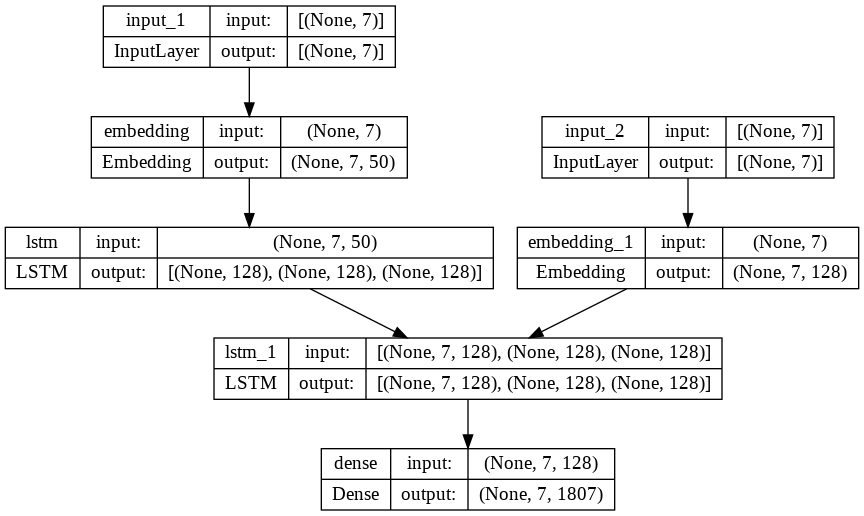

In [ ]:
# Modelo completo (encoder+decoder) para poder entrenar
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

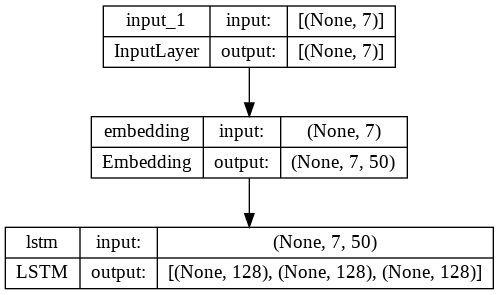

In [ ]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

from keras.utils.vis_utils import plot_model
plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

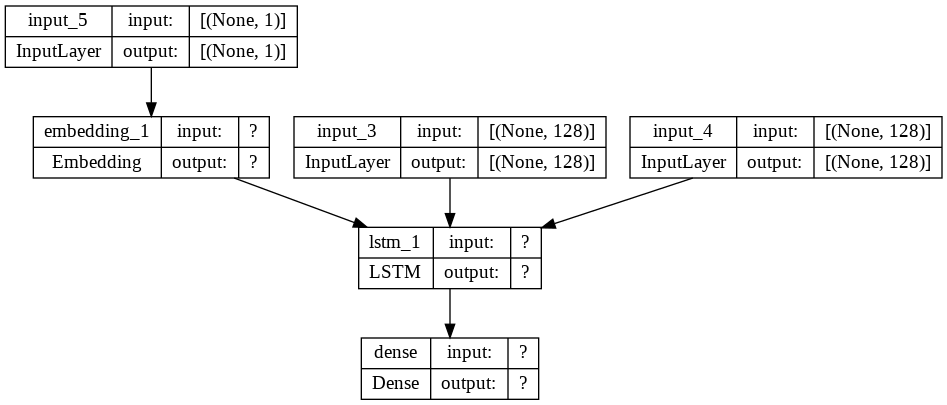

In [ ]:
# Modelo solo decoder (para realizar inferencia)
from keras.utils.vis_utils import plot_model

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=30, 
    validation_split=0.2)

Epoch 1/30
151/151 [==============================] - 12s 16ms/step - loss: 3.8632 - accuracy: 0.3524 - val_loss: 3.1710 - val_accuracy: 0.4754
Epoch 2/30
151/151 [==============================] - 2s 11ms/step - loss: 2.8190 - accuracy: 0.5070 - val_loss: 2.8600 - val_accuracy: 0.5410
Epoch 3/30
151/151 [==============================] - 2s 10ms/step - loss: 2.4515 - accuracy: 0.5814 - val_loss: 2.6621 - val_accuracy: 0.5775
Epoch 4/30
151/151 [==============================] - 2s 10ms/step - loss: 2.2327 - accuracy: 0.6109 - val_loss: 2.5432 - val_accuracy: 0.5876
Epoch 5/30
151/151 [==============================] - 2s 10ms/step - loss: 2.0908 - accuracy: 0.6261 - val_loss: 2.4649 - val_accuracy: 0.5971
Epoch 6/30
151/151 [==============================] - 2s 10ms/step - loss: 1.9873 - accuracy: 0.6398 - val_loss: 2.4130 - val_accuracy: 0.6060
Epoch 7/30
151/151 [==============================] - 2s 10ms/step - loss: 1.9073 - accuracy: 0.6463 - val_loss: 2.3797 - val_accuracy: 0.605

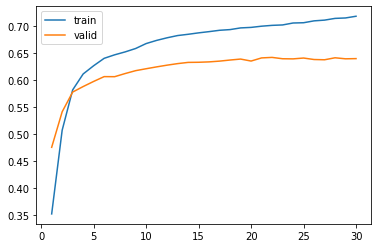

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [ ]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [ ]:
# Prueba con n frases randoms

n = 10
for _ in range(n): 
    i = np.random.choice(len(input_sentences))
    input_seq = encoder_input_sequences[i:i+1]
    translation = translate_sentence(input_seq)
    
    print(f'Input: \033[1m{input_sentences[i]}\033[0m, Tokens ids con padding: {input_seq}')
    print(f'Response: \033[1m{translation}\033[0m \n')

1/1 [==============================] - 0s 17ms/step
Input: samosa, Tokens ids con padding: [[   0    0    0    0    0    0 1046]]
Response: i love to read 

1/1 [==============================] - 0s 16ms/step
Input: what do you do for a living , Tokens ids con padding: [[ 4  3  2  3  8  5 13]]
Response: i am a student 

1/1 [==============================] - 0s 18ms/step
Input: hello, Tokens ids con padding: [[ 0  0  0  0  0  0 19]]
Response: hello how are you 

1/1 [==============================] - 0s 26ms/step
Input: i like blue i like blue , Tokens ids con padding: [[  0   1  12 142   1  12 142]]
Response: i like to play video games 

1/1 [==============================] - 0s 18ms/step
Input: either or maybe either, Tokens ids con padding: [[  0   0   0 350 108 358 350]]
Response: i like to play video games 

1/1 [==============================] - 0s 19ms/step
Input: i love to read, Tokens ids con padding: [[ 0  0  0  1 14  6 23]]
Response: i like to play video games 

1/1 [=======

In [ ]:
# Prueba con una frase específica

i = np.random.choice(len(input_sentences))
#print('input_sentences :',input_sentences)
print('\ninput_sentences :',input_sentences[i:i+1])
input_seq = encoder_input_sequences[i:i+1]
print('input_seq :',input_seq)
translation = translate_sentence(input_seq)
print('-')
print(f'Input: {input_sentences[i]} Response: {translation}\n')
#print('Response:', translation)


input_sentences : ['and lime green']
input_seq : [[   0    0    0    0   38 1042  325]]
1/1 [==============================] - 0s 17ms/step
-
Input: and lime green Response: i am a teacher



In [ ]:
# Prueba con frases especificas  
    
textos = ["Hello", "goodbye", "who is her favorite singer?", "are you an engineer?", 
          "what do you do for a living?", "how much does this car cost?",
          "what do you like?", "do you have any hobbies?",
          "how old are you?", "Do you read?", "where do you live?",
          "Do you have any pet?", "Where are you from?", "what are you like",
          "what does she likes?", "Is she an student?", "Is she a student?", 
          "how old is she?", "where does she live?", "what do you read"]    

for input_test in textos:
    integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
    encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
    translation = translate_sentence(encoder_sequence_test)
    print(f'Input: \033[1m{input_test}\033[0m, Tokens ids con padding: {encoder_sequence_test}')
    print(f'Response: \033[1m{translation}\033[0m \n')

1/1 [==============================] - 0s 17ms/step
Input: Hello, Tokens ids con padding: [[ 0  0  0  0  0  0 19]]
Response: hello how are you 

1/1 [==============================] - 0s 17ms/step
Input: goodbye, Tokens ids con padding: [[  0   0   0   0   0   0 564]]
Response: i love to read 

1/1 [==============================] - 0s 20ms/step
Input: who is her favorite singer?, Tokens ids con padding: [[  0   0 117  15 349  62 257]]
Response: i like to play video games 

1/1 [==============================] - 0s 19ms/step
Input: are you an engineer?, Tokens ids con padding: [[  0   0   0   7   2 196 353]]
Response: i am a teacher 

1/1 [==============================] - 0s 19ms/step
Input: what do you do for a living?, Tokens ids con padding: [[ 4  3  2  3  8  5 13]]
Response: i am a student 

1/1 [==============================] - 0s 18ms/step
Input: how much does this car cost?, Tokens ids con padding: [[  0   0  10 146 330 174 246]]
Response: i am a teacher 

1/1 [===============

### Conclusión

Se utilizó una red neuronal con embeddings de Glove de dimension 50 y una capa de entrada de 128 unidades. Con una capa de entrada mas grande se produjo un overfeeting mayor.\
Se agregó un dropout de 20% en la primera capa LSTM y de un 40% en la segunda capa LSTM. El entrenamiento se realizó con 30 épocas pero se ve que si bien el accuracy de entrenamiento va mejorando, el accuracy de validación varía muy poco, por lo cual decidí no incrementar la cantidad de épocas de entrenamiento.\
El largo máximo de las sentencias de entrada y de salida se estableció en 7, con sentencias mas largas los resultados se repiten mucho. Con un máximo mas chico para entradas y salidas, las fases se cortan y los resultados son peores. Entiendo que esto se debe a que cuanto mas largas son las frases, el padding debe ser mas grande (es decir que se agregan mas ceros) y la convergencia se produce hacia los mismos resultados con entradas distintas. \

Se probó con 10 frases tomadas en forma aleatoria del corpus y con las siguientes 20 frases : “Hello”, "goodbye", "who is her favorite singer?", "are you an engineer?", "what do you do for a living?", "how much does this car cost?", "what do you like?", "do you have any hobbies?", "how old are you?", "Do you read?", "where do you live?", "Do you have any pet?", "Where are you from?", "what are you like", "what does she likes?", "Is she an student?", "Is she a student?", "how old is she?", "where does she live?" y "what do you read”.

Los resultados fueron bastante variados
- Algunos fueron buenos como : \
Entrada : Hello >>>> Respuesta :  hello how are you \
Entrada: Do you read >>>> Respuesta: i love to read \
Entrada: what do you do for a living? >>>> Respuesta: i am a student \
Entrada: are you an engineer?, >>>> Respuesta: i am a teacher 

- Otros tienen algunas cosas rescatables como : \
Entrada: what do you read >>>> Respuesta: i like to play video games \
Entrada: what does she likes? >>>> Respuesta: i like to go to the beach 

- Otros dan respuestas que no tienen mucho sentido, como : \
Entrada: Is she a student? >>>> Respuesta: what do you do for a living \
Entrada: where does she live? >>>> Respuesta: i like to go to the beach \

